In [1]:
%matplotlib inline

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from collections import namedtuple
from fuel.datasets.hdf5 import H5PYDataset


BATH_SIZE = 100
IMG_SIZE = 256

# Img resizing stuff
LR_HR_RATIO = 4
BIG_SIZE = int(IMG_SIZE * 76 / 64)
SMALL_SIZE = int(BIG_SIZE / LR_HR_RATIO)

DATA_TEMPLATE =             '/fashion/ssense_%i_%i.h5'
LANGUAGE_MODEL_FILE =       '/data/glove/glove.6B.300d.txt'
LANGUAGE_MODEL_VOCABULARY = '/data/glove/glove.6B.vocab'

FASTTEXT_DATA =             '/data/fashion/txt/fashion.dedup.txt'
FASTTEXT_DATA_TRAIN =       '/data/fashion/txt/fashion-train.txt'
FASTTEXT_DATA_CLEAN =       '/data/fashion/txt/fashion-clean.txt'

OUTPUT =                    '/data/classes_and_texts.txt'

In [3]:
data_set = H5PYDataset(DATA_TEMPLATE % (IMG_SIZE, IMG_SIZE), which_sets=('all',))

In [4]:
def list_keys(data_set): 
    return [k.split('_')[1] for k in sorted(data_set.axis_labels.keys())]

In [5]:
for i, key in enumerate(list_keys(data_set)):
    print("%d %s" % (i, key))

0 brand
1 category
2 composition
3 department
4 description
5 gender
6 image
7 msrpUSD
8 name
9 productID
10 season
11 subcategory


In [6]:
Item = namedtuple('Item', ' '.join(list_keys(data_set)))

In [7]:
import string
from collections import Counter

BLACK_LIST = string.punctuation.replace('%', '') + '\n'

def normalize(text_array, 
    black_list = BLACK_LIST, 
    vocab=None, lowercase =  True, tokenize = False):
    text = text_array[0]
    if black_list:
        text = text.translate(None, BLACK_LIST)
    if lowercase:
        text = text.lower()
    if vocab:
        text = ' '.join([word for word in text.split() if word in vocab])
    if tokenize:
        return text.split()
    return text

In [9]:
def dump_for_keras(
    data_set, output, 
    batch_size = BATH_SIZE, limit=None, vocab=None):
    '''
    Dumps the hdf5 dataset to flat textfile
    '''
    N = data_set.num_examples
    num_batch = N / batch_size + 1
    
    handle = data_set.open()
    with open(output, 'wr') as f:
        processed = 0
        for i in itertools.islice(xrange(num_batch), limit):
            # fetch batch of data
            low, high = i*batch_size, min((i+1)*batch_size, data_set.num_examples)
            rows = data_set.get_data(handle, slice(low, high))
            
            # process batch
            classes = [row[0].replace(" ", "_") for row in rows[1]]
            texts = [normalize(text, vocab=vocab) for text in rows[4]]
            lines = ["%s %s\n" % (c, t) for c,t in zip(classes, texts)]
            # dumplines
            f.writelines(lines)
             
            if i % 100 == 0:
                percent = int(((100.0 * i )/ num_batch))
                print("Low: %d, high: %d" % (low, high))
                print("Processing %i batch out of %i [%i processed]" % (i, num_batch, processed))
            
            # track progress 
            processed += len(texts)  

## Some sanity checks

In [174]:
import itertools
import math

tokens = Counter()
classes = Counter()
ids = set()

handle = data_set.open()
num_batch = data_set.num_examples / BATH_SIZE + 1
for i in xrange(num_batch):
    if i % 100 == 0:
        percent = int(((100.0 * i )/ num_batch))
        print("Processing %i batch out of %i [%i percent]" % (i, num_batch, percent))
        print("Number of tokens in the dictionary: %i" % len(tokens))
        print("Number of classes in the dictionary: %i" % len(classes))
    
    low, high = i*BATH_SIZE, min((i+1)*BATH_SIZE, data_set.num_examples)
    rows = data_set.get_data(handle, slice(low, high))
    
    tokens.update(itertools.chain(*[
        normalize(text[0], tokenize=True) for text in rows[4]
    ]))
    classes.update(itertools.chain([
        row[0] for row in rows[1]
    ]))
    ids.update([x[0] for x in rows[9]])

Processing 0 batch out of 738 [0 percent]
Number of tokens in the dictionary: 0
Number of classes in the dictionary: 0
Processing 100 batch out of 738 [13 percent]
Number of tokens in the dictionary: 4400
Number of classes in the dictionary: 20
Processing 200 batch out of 738 [27 percent]
Number of tokens in the dictionary: 5796
Number of classes in the dictionary: 25
Processing 300 batch out of 738 [40 percent]
Number of tokens in the dictionary: 6763
Number of classes in the dictionary: 44
Processing 400 batch out of 738 [54 percent]
Number of tokens in the dictionary: 7740
Number of classes in the dictionary: 48
Processing 500 batch out of 738 [67 percent]
Number of tokens in the dictionary: 8502
Number of classes in the dictionary: 49
Processing 600 batch out of 738 [81 percent]
Number of tokens in the dictionary: 9110
Number of classes in the dictionary: 49
Processing 700 batch out of 738 [94 percent]
Number of tokens in the dictionary: 9657
Number of classes in the dictionary: 49

In [175]:
print("There are %s distinct words in the dataset" % len(tokens))
print("There are %s distinct classes in the dataset" % len(classes))
print("There are %s distinct ids in the dataset" % len(ids))

There are 9887 distinct words in the dataset
There are 49 distinct classes in the dataset
There are 73761 distinct ids in the dataset


In [176]:
tokens.most_common(10)

[('at', 139189),
 ('in', 114972),
 ('tonal', 80500),
 ('stitching', 69965),
 ('and', 63633),
 ('black', 49446),
 ('sleeve', 46781),
 ('collar', 42710),
 ('front', 35861),
 ('long', 28799)]

# Are we missing something?

In [15]:
with open(LANGUAGE_MODEL_FILE, 'rt') as f:
    vocab = set([line.split(" ")[0] for line in f.readlines()])

In [37]:
missing_words = Counter({ word: tokens[word] for word in tokens if word.lower() not in vocab})
print("There are %i missing words out of %i" % (len(missing_words), len(tokens)))
print("Most common mising words")
missing_words.most_common(10)

There are 3742 missing words out of 9882
Most common mising words


[('tshirt', 9629),
 ('goldtone', 6639),
 ('pressstud', 6007),
 ('zipfly', 5692),
 ('slimfit', 4689),
 ('singlebutton', 4574),
 ('fivepocket', 4104),
 ('fourpocket', 3827),
 ('twoway', 3203),
 ('relaxedfit', 2588)]

# Sample data

In [177]:
import scipy.misc
import random

def clean_plot(img):
    plt.imshow(img); plt.xticks([]); plt.yticks([]); plt.show()
    
def clean_plot_dpi(img, size, dpi=60):
    plt.figure().set_size_inches(float(size)/float(dpi),float(size)/float(dpi))
    plt.xticks([]); plt.yticks([]);
    plt.imshow(img);

In [200]:
i = random.randint(0, data_set.num_examples)
item = Item._make(data_set.get_data(handle, slice(i, min((i+1), data_set.num_examples))))

Raw text: 
Long sleeve sweatshirt in pink. Crewneck collar. Signature tiger's head embroidery at front panel in tones of pink. Tonal stitching.

Normalized text: 
long sleeve sweatshirt in pink crewneck collar signature tigers head embroidery at front panel in tones of pink tonal stitching

Normalized text with vocab: 
long sleeve sweatshirt in pink crewneck collar signature tigers head embroidery at front panel in tones of pink tonal stitching



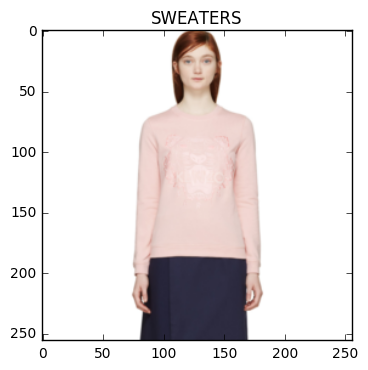

In [201]:
plt.title(item.category[0][0])
plt.imshow(item.image[0]);
print("Raw text: \n%s\n" % item.description[0][0])
print("Normalized text: \n%s\n" %  ' '.join(
    normalize(item.description[0][0], tokenize=True)))
print("Normalized text with vocab: \n%s\n" %  ' '.join(
    normalize(item.description[0][0], vocab=vocab, tokenize=True)))
plt.show()

## To be consistent with StackGAN

In [181]:
img = item.image[0]
img_76 = scipy.misc.imresize(img, [SMALL_SIZE, SMALL_SIZE], 'bicubic')
img_304 = scipy.misc.imresize(img, [BIG_SIZE, BIG_SIZE], 'bicubic')

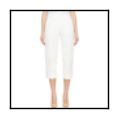

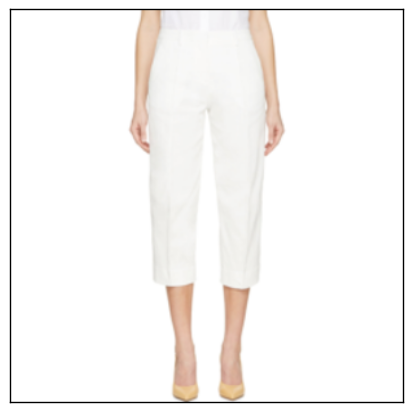

In [182]:
clean_plot_dpi(img_76, SMALL_SIZE); clean_plot_dpi(img_304, BIG_SIZE);

# Dump data for text embedding with CNN

In [ ]:
dump_for_keras(data_set, OUTPUT, batch_size = BATH_SIZE, vocab=None)

## Load data ;)

In [65]:
with open(OUTPUT, 'rt') as f:
    classes, texts = zip(*[line.split(" ", 1) for line in f.readlines()])

In [66]:
c = Counter([len(t.split(' ')) for t in texts])

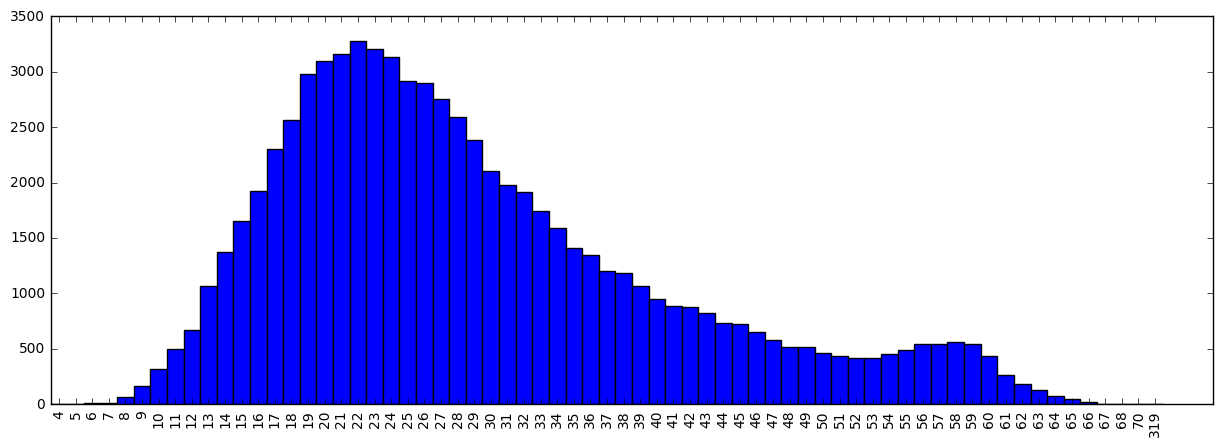

In [67]:
labels, values = zip(*c.items())

indexes = np.arange(len(labels))
width = 1

plt.figure(figsize=(15, 5))
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels, rotation=90)
plt.show()

## Classes

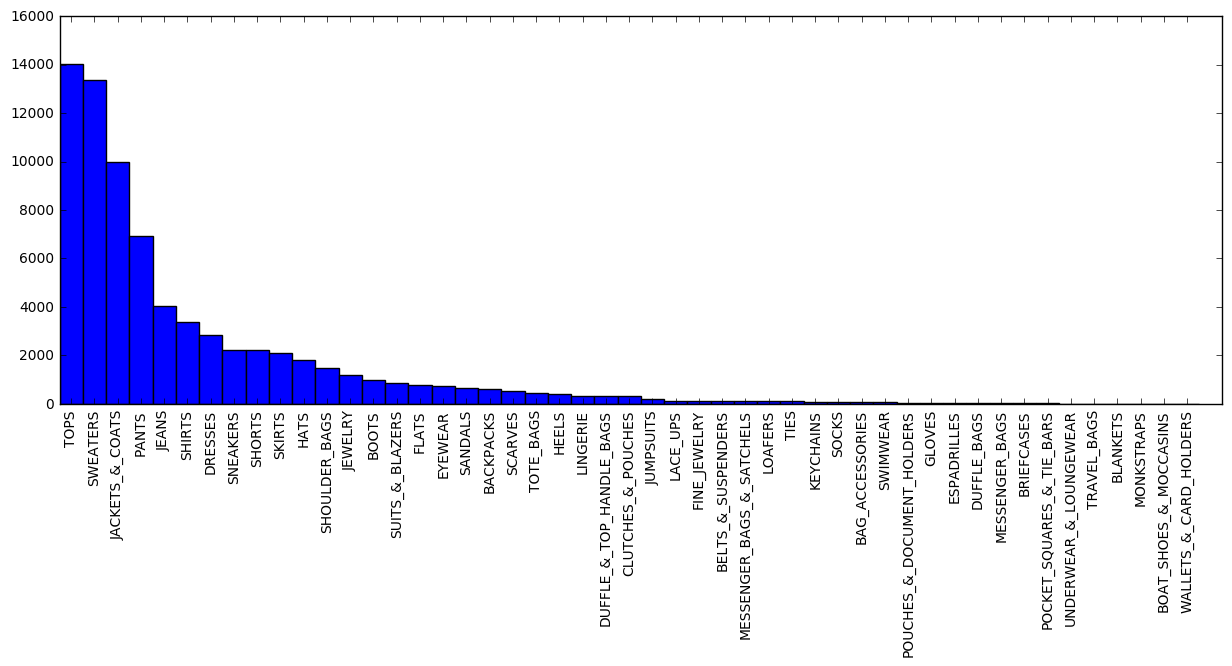

In [70]:
class_counts = Counter(classes)
labels, values = zip(*class_counts.most_common())

indexes = np.arange(len(labels))
width = 1

plt.figure(figsize=(15, 5))
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels, rotation=90)
plt.show()

In [146]:
import os
import sys
import logging

In [83]:
sys.path.append(os.path.abspath('../'))

In [144]:
from embedding.train_embedding_model import load_and_process, train_val_split

In [147]:
data, labels, tokenizer = load_and_process('/data/classes_and_texts.txt', 10000, 70, True)

2018-02-27 00:23:22,154 [INFO] Class statistics
2018-02-27 00:23:22,155 [INFO] Found 49 classes
2018-02-27 00:23:22,156 [INFO] 	 TOPS: 14040
2018-02-27 00:23:22,158 [INFO] 	 SWEATERS: 13355
2018-02-27 00:23:22,159 [INFO] 	 JACKETS_&_COATS: 9991
2018-02-27 00:23:22,162 [INFO] 	 PANTS: 6914
2018-02-27 00:23:22,164 [INFO] 	 JEANS: 4029
2018-02-27 00:23:22,165 [INFO] 	 SHIRTS: 3357
2018-02-27 00:23:22,166 [INFO] 	 DRESSES: 2852
2018-02-27 00:23:22,167 [INFO] 	 SNEAKERS: 2237
2018-02-27 00:23:22,168 [INFO] 	 SHORTS: 2200
2018-02-27 00:23:22,169 [INFO] 	 SKIRTS: 2108
2018-02-27 00:23:22,169 [INFO] 	 HATS: 1790
2018-02-27 00:23:22,170 [INFO] 	 SHOULDER_BAGS: 1456
2018-02-27 00:23:22,171 [INFO] 	 JEWELRY: 1181
2018-02-27 00:23:22,172 [INFO] 	 BOOTS: 964
2018-02-27 00:23:22,173 [INFO] 	 SUITS_&_BLAZERS: 869
2018-02-27 00:23:22,174 [INFO] 	 FLATS: 780
2018-02-27 00:23:22,175 [INFO] 	 EYEWEAR: 739
2018-02-27 00:23:22,176 [INFO] 	 SANDALS: 658
2018-02-27 00:23:22,177 [INFO] 	 BACKPACKS: 610
2018-0

In [148]:
x_train, y_train, x_val, y_val = train_val_split(data, labels, 0.1)

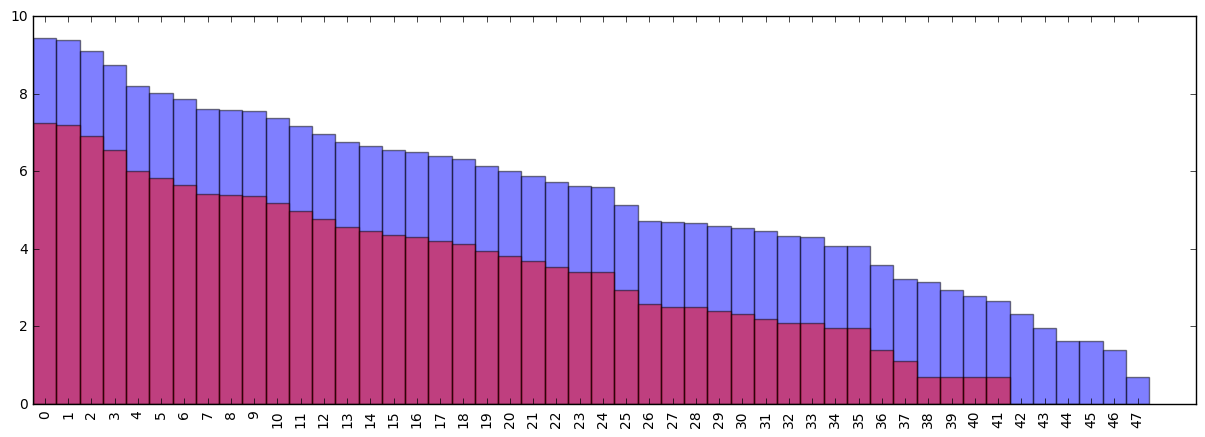

In [152]:
train_c = Counter(np.argmax(y_train, axis=1)).most_common()
val_c = Counter(np.argmax(y_val, axis=1)).most_common()

labels_t, values_t = zip(*train_c)
labels_v, values_v = zip(*val_c)

width = 1

plt.figure(figsize=(15, 5))
plt.bar(np.arange(len(labels_t)), np.log(values_t), width, alpha=0.5)
plt.bar(np.arange(len(labels_v)), np.log(values_v), width, color = 'red', alpha=0.5)
plt.xticks(indexes + width * 0.5, labels_t, rotation=90)
plt.show()

In [184]:
# Sanity check for the distribution of classes
for a, b in zip(values_v, values_t):
    print("%0.4f, %0.4f" % (a/ (1.0 * sum(values_v)), b/(1.0*sum(values_t))))

0.1903, 0.1903
0.1810, 0.1811
0.1354, 0.1355
0.0937, 0.0937
0.0546, 0.0546
0.0456, 0.0455
0.0386, 0.0387
0.0304, 0.0303
0.0298, 0.0298
0.0286, 0.0286
0.0243, 0.0243
0.0197, 0.0197
0.0160, 0.0160
0.0130, 0.0131
0.0118, 0.0118
0.0106, 0.0106
0.0100, 0.0100
0.0089, 0.0089
0.0083, 0.0083
0.0069, 0.0069
0.0061, 0.0061
0.0054, 0.0054
0.0046, 0.0046
0.0041, 0.0041
0.0041, 0.0040
0.0026, 0.0025
0.0018, 0.0017
0.0016, 0.0016
0.0016, 0.0016
0.0015, 0.0015
0.0014, 0.0014
0.0012, 0.0013
0.0011, 0.0011
0.0011, 0.0011
0.0009, 0.0009
0.0009, 0.0009
0.0005, 0.0005
0.0004, 0.0004
0.0003, 0.0003
0.0003, 0.0003
0.0003, 0.0002
0.0003, 0.0002
0.0001, 0.0002
0.0001, 0.0001
0.0001, 0.0001
